In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit as cv
import numpy as np
import pickle

# Labs 7 and 8

In [3]:
# open the file of interest, and use pickle loading
infile = open ("Sample_pt_250_500/qcd_100000_pt_250_500.pkl",'rb')
qcd_data = pickle.load(infile)
higgs_data = pickle.load(open ("Sample_pt_250_500/higgs_100000_pt_250_500.pkl",'rb'))

# list all keys of the files
print(qcd_data.keys())

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


In [4]:

def histograms(var, name, units):
    plt.rcParams["figure.figsize"] = (15,10)  
    fig, ax = plt.subplots(1, 2)

    ax[0].hist(qcd_data.get(var), color = 'red', alpha=0.5, label = 'QCD data', bins = 27)
    ax[0].hist(higgs_data.get(var), alpha=0.5, label='Higgs data', bins = 27)
    ax[1].hist(qcd_data.get(var), color = 'red', alpha=0.5, label = 'QCD data', bins = 27)
    ax[1].hist(higgs_data.get(var), alpha=0.5, label='Higgs data', bins = 27)

    ax[0].set_title('Histograms of Higgs ' + name + ' with QCD '+ name)
    ax[0].set_ylabel('Counts')
    ax[0].set_xlabel(r'' + name + ' (' + units + ')')
    ax[0].legend()

    ax[1].set_title('Histograms of Higgs ' + name + ' with QCD '+ name)
    ax[1].set_ylabel('log[Counts]')
    ax[1].set_xlabel(r'' + name + ' (' + units + ')')
    ax[1].legend()
    ax[1].set_yscale('log')
    
    return ax

To begin this lab, I will make a stacked histogram plot for the mass 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40994fbd30>,
      dtype=object)

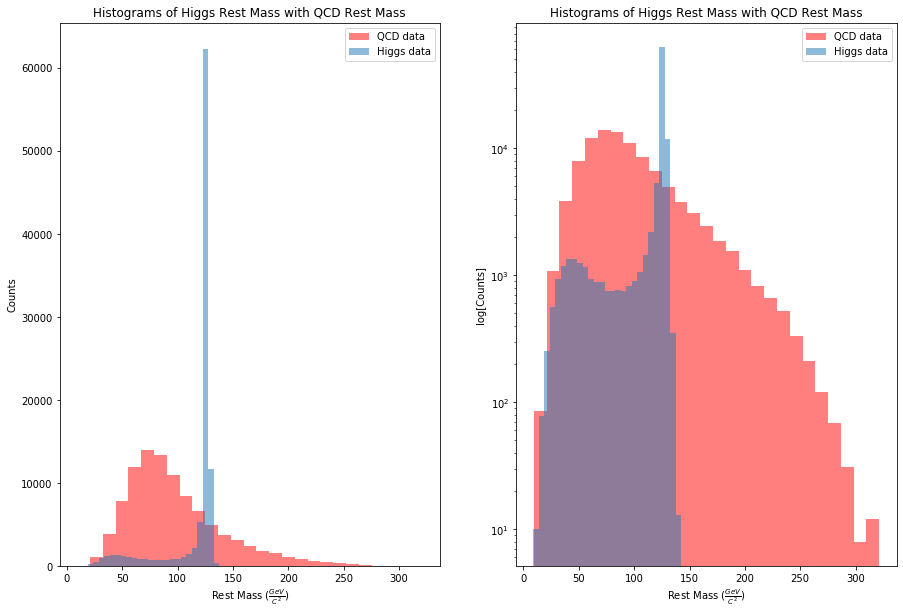

In [5]:
histograms('mass', 'Rest Mass', r'$\frac{GeV}{C^2}$')

In [6]:
background_count = 20000 # given in dataset
total_count = background_count + 100 # given in dataset

prob = stats.poisson.sf(total_count, mu=background_count)

print('Significance: \t',prob)

sn_ratio = (100) / (20000**0.5)

print('Ratio:         \t', sn_ratio)

Significance: 	 0.23847212190687442
Ratio:         	 0.7071067811865475


The ratio of $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$ represents the ratio of the number of Higgs particles in our data set vs the standard deviation of the QCD background.  If this number is smaller than one, then the number of Higgs is inside of the standard deviation of the background, which is the case here.

For the QCD backgound, I only got a significance of 23.8%, which means that about a quarter of the time, I'd expect a number of events equal to the number I detected or higher.

To approach the problem of doing cuts to increase my significance, I must first weight the two distributions given that their are 100 Higgs counts and 20000 QCD counts in our data set.

In [7]:
weight_higgs = higgs_data.get('mass').size / 100
weight_qcd = qcd_data.get('mass').size / 20000
print('Weight Higgs:\t',weight_higgs)
print('Weight QCD:\t',weight_qcd)

Weight Higgs:	 1000.0
Weight QCD:	 5.0


What this means is that 1000 Higgs counts in my data set corrospond to one Higgs detection and every 5 QCD counts in my data set corrospond to one QCD detection.  I can know cut the background to maximize my significance.

In [8]:
cut_level = 0
minimum_cut_level = 110
minimum_cut_sig = 1
significance = 1
five_sigma = stats.norm.sf(5)

while significance > five_sigma:
    cut_level += 0.1
    higgs_count = np.count_nonzero(higgs_data.get('mass') > cut_level) / weight_higgs
    qcd_count = np.count_nonzero(qcd_data.get('mass') > cut_level) / weight_qcd 
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    
    if significance < minimum_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
        minimum_cut_sig = significance
        minimum_cut_level = cut_level

        
max_cut_level = 140
max_cut_sig = 1
cut_level = int(qcd_data.get('mass').max())
significance = 1
while significance > five_sigma:
    cut_level -= 0.1
    higgs_count = np.count_nonzero((higgs_data.get('mass') > minimum_cut_level) & (higgs_data.get('mass') < cut_level)) / weight_higgs
    qcd_count = np.count_nonzero((qcd_data.get('mass') > minimum_cut_level) & (qcd_data.get('mass') < cut_level)) / weight_qcd
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    
    if significance < max_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
        max_cut_level = cut_level
        max_cut_sig = significance
  

higgs_count = np.count_nonzero((higgs_data.get('mass') > minimum_cut_level) & (higgs_data.get('mass') < max_cut_level)) / weight_higgs
qcd_count = np.count_nonzero((qcd_data.get('mass') > minimum_cut_level) & (qcd_data.get('mass') < max_cut_level)) / weight_qcd
significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
print('Min Cut Level:\t', np.round(minimum_cut_level, decimals=2))
print('Max Cut Level:\t', np.round(max_cut_level, decimals=2))
print('Significance:\t', significance)
print('Higgs Counts:\t',int(higgs_count))
print('QCD Counts:\t',int(qcd_count) )

Min Cut Level:	 119.3
Max Cut Level:	 129.0
Significance:	 0.009418115498960086
Higgs Counts:	 73
QCD Counts:	 975


Note, it is actually impossible to get a $5\sigma$ significance on the mass because you start cutting out too much signal.

(119.3, 129)

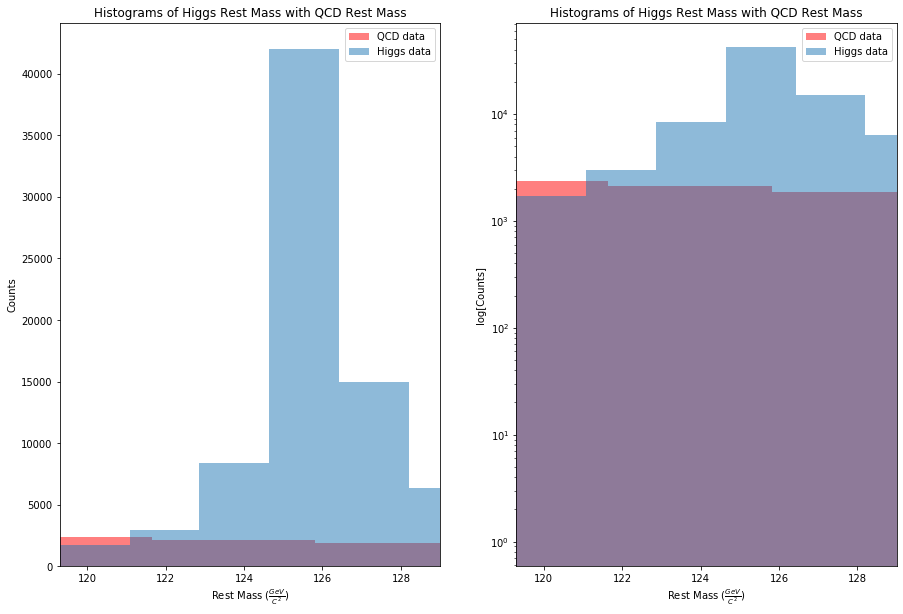

In [9]:
plt.rcParams["figure.figsize"] = (15,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(qcd_data.get('mass'), color = 'red', alpha=0.5, label = 'QCD data', bins = 75)
ax[0].hist(higgs_data.get('mass'), alpha=0.5, label='Higgs data', bins = 75)
ax[1].hist(qcd_data.get('mass'), color = 'red', alpha=0.5, label = 'QCD data', bins = 75)
ax[1].hist(higgs_data.get('mass'), alpha=0.5, label='Higgs data', bins = 75)

ax[0].set_title('Histograms of Higgs ' + 'Rest Mass' + ' with QCD ' + 'Rest Mass')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel(r'Rest Mass ($\frac{GeV}{C^2}$)')
ax[0].legend()

ax[1].set_title('Histograms of Higgs ' + 'Rest Mass' + ' with QCD ' + 'Rest Mass')
ax[1].set_ylabel('log[Counts]')
ax[1].set_xlabel(r'Rest Mass ($\frac{GeV}{C^2}$)')
ax[1].legend()
ax[1].set_yscale('log')
ax[0].set_xlim([119.3,129])
ax[1].set_xlim([119.3,129])

In [10]:
print(higgs_count/ (qcd_count**0.5))

2.36146996546336


In [55]:
def make_cuts(var, min_start, max_start):
    min_higgs = 25 # want to keep at least 25% of our Higgs data
    interval = (max_start - min_start) / 1000
    cut_level = min_start
    minimum_cut_level = min_start
    minimum_cut_sig = 0
    sn_ratio = 1

    while cut_level < max_start:
        cut_level += interval
        higgs_count = np.count_nonzero(higgs_data.get(var) > cut_level) / weight_higgs
        qcd_count = np.count_nonzero(qcd_data.get(var) > cut_level) / weight_qcd 
        
        if higgs_count <= 0.0 or qcd_count <= 0:
            continue
            
        sn_ratio = higgs_count / (qcd_count + higgs_count)
        if higgs_count > min_higgs and sn_ratio > minimum_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
            minimum_cut_sig = sn_ratio
            minimum_cut_level = cut_level


    max_cut_level = max_start
    max_cut_sig = 0
    cut_level = max_start
    sn_ratio = 0
    while cut_level > minimum_cut_level:
        cut_level -= interval
        higgs_count = np.count_nonzero((higgs_data.get(var) > minimum_cut_level) & (higgs_data.get(var) < cut_level)) / weight_higgs
        qcd_count = np.count_nonzero((qcd_data.get(var) > minimum_cut_level) & (qcd_data.get(var) < cut_level)) / weight_qcd 
        
        if higgs_count <= 0.0 or qcd_count <= 0:
            continue
        
        sn_ratio = higgs_count / (qcd_count + higgs_count)
        if higgs_count > min_higgs and sn_ratio > max_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
            max_cut_level = cut_level
            max_cut_sig = sn_ratio


    higgs_count = np.count_nonzero((higgs_data.get(var) > minimum_cut_level) & (higgs_data.get(var) < max_cut_level)) / weight_higgs
    qcd_count = np.count_nonzero((qcd_data.get(var) > minimum_cut_level) & (qcd_data.get(var) < max_cut_level)) / weight_qcd 
    sn_ratio = higgs_count / (qcd_count + higgs_count)
    print('Min Cut Level:\t\t', np.round(minimum_cut_level, decimals=int(-1*np.log10(interval))))
    print('Max Cut Level:\t\t', np.round(max_cut_level, decimals=int(-1*np.log10(interval))))
    print('Signal-noise Ratio:\t', sn_ratio)
    print('Higgs Counts:\t\t',int(higgs_count))
    print('QCD Counts:\t\t',int(qcd_count))
    
    return [minimum_cut_level, max_cut_level]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40981aab00>,
      dtype=object)

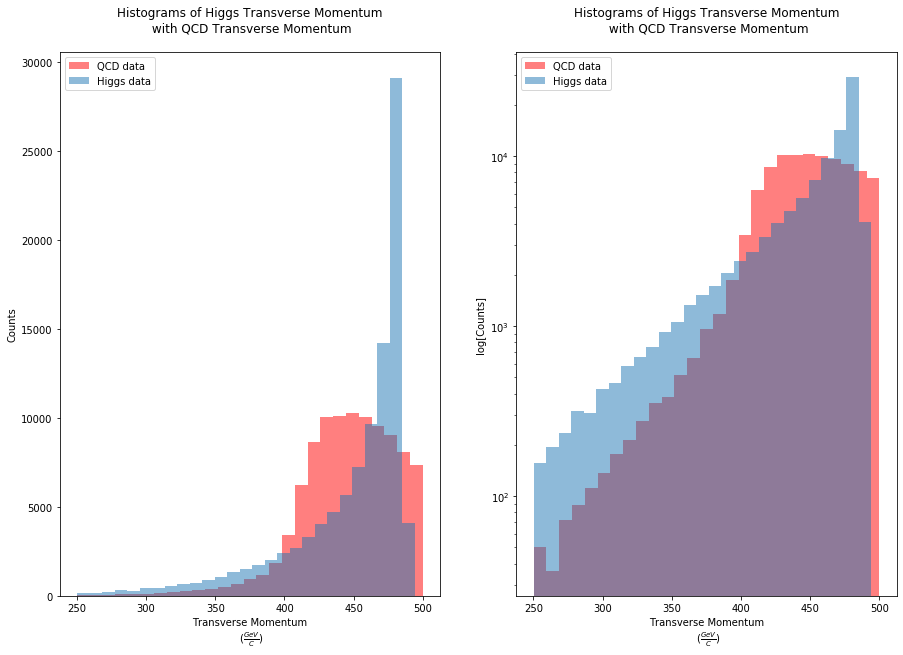

In [56]:
histograms('pt', 'Transverse Momentum\n', r'$\frac{GeV}{C}$')

In [57]:
weight_higgs = higgs_data.get('pt').size / 100
weight_qcd = qcd_data.get('pt').size / 20000
print('Weight Higgs:\t',weight_higgs)
print('Weight QCD:\t',weight_qcd)

Weight Higgs:	 1000.0
Weight QCD:	 5.0


Min Cut Level:		 473.7
Max Cut Level:		 485.7
Signal-noise Ratio:	 0.015539428178372595
Higgs Counts:		 35
QCD Counts:		 2255


(473.70000000001676, 485.69999999999675)

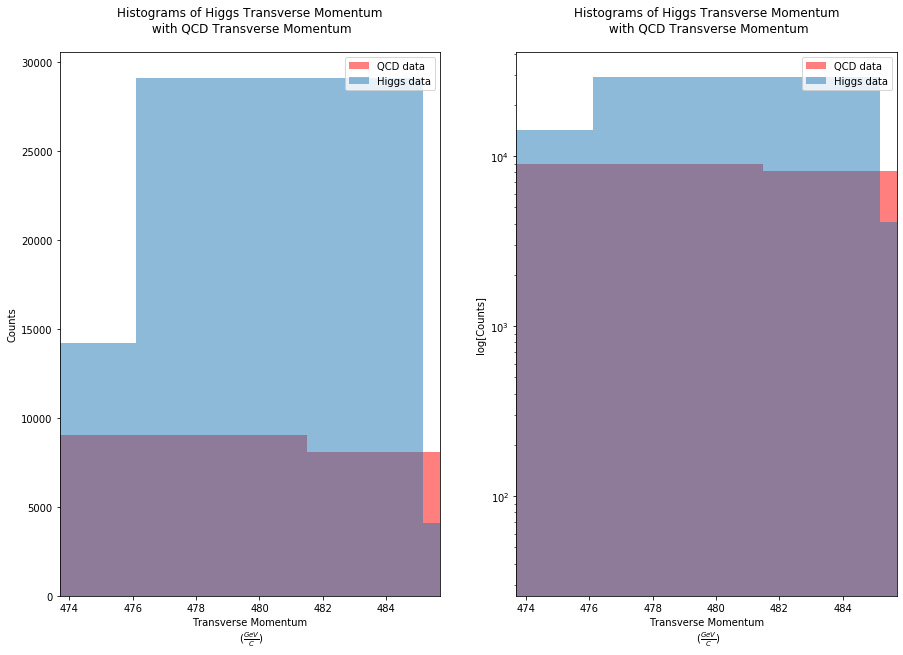

In [58]:
minimum_cut_level = 400
max_cut_level = 500
[minimum_cut_level, max_cut_level] = make_cuts('pt', minimum_cut_level, max_cut_level)

ax = histograms('pt', 'Transverse Momentum\n', r'$\frac{GeV}{C}$')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

Min Cut Level:		 -0.95
Max Cut Level:		 0.51
Signal-noise Ratio:	 0.0069404668584037805
Higgs Counts:		 54
QCD Counts:		 7817


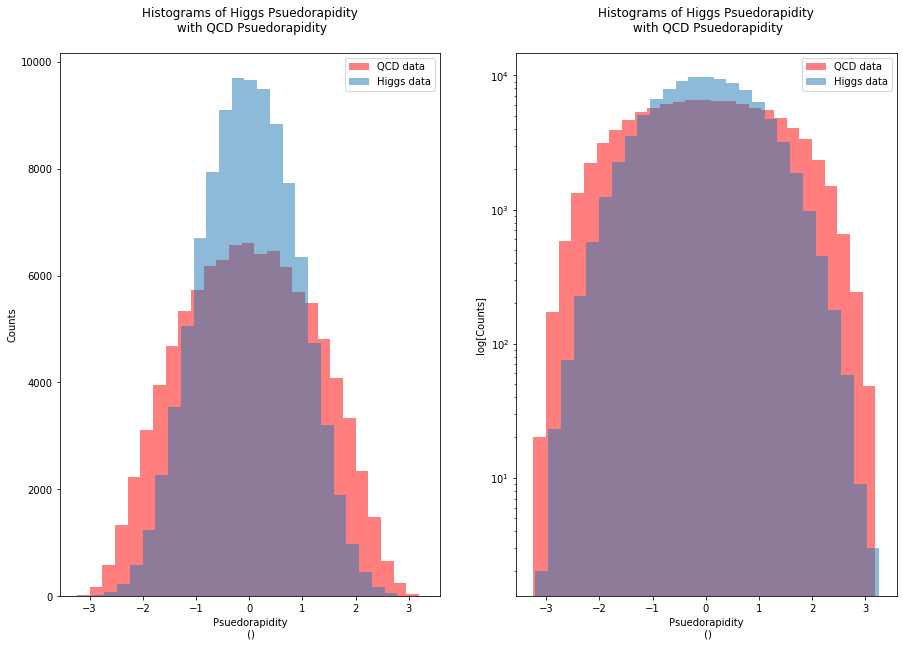

In [59]:
histograms('eta', 'Psuedorapidity\n', r'')
minimum_cut_level = -3
max_cut_level = 3
[minimum_cut_level, max_cut_level] = make_cuts('eta', minimum_cut_level, max_cut_level)

(-0.948000000000035, 0.5100000000000346)

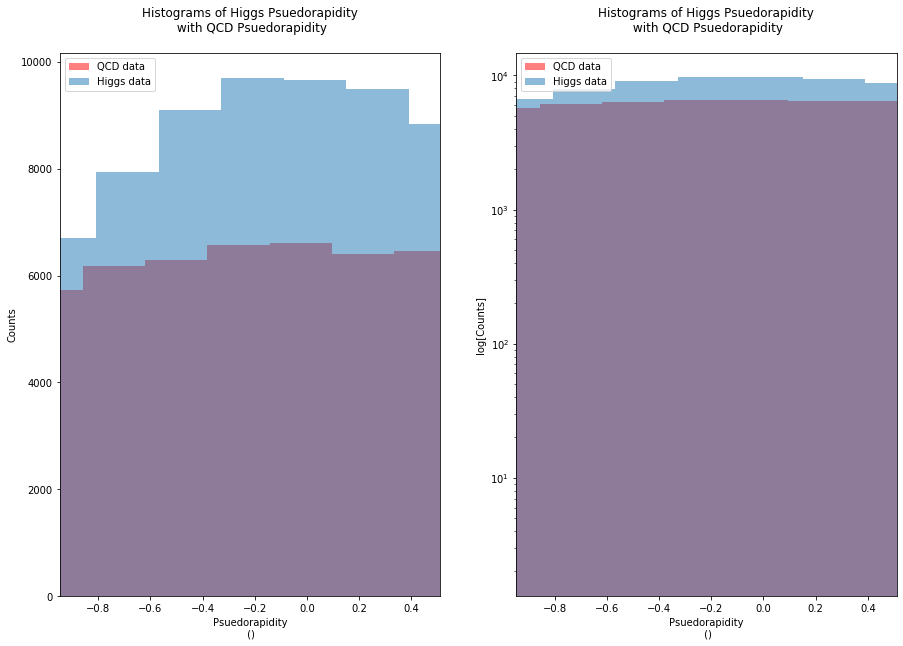

In [60]:
ax = histograms('eta', 'Psuedorapidity\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

Min Cut Level:		 0.123
Max Cut Level:		 0.153
Signal-noise Ratio:	 0.026667123464067966
Higgs Counts:		 45
QCD Counts:		 1647


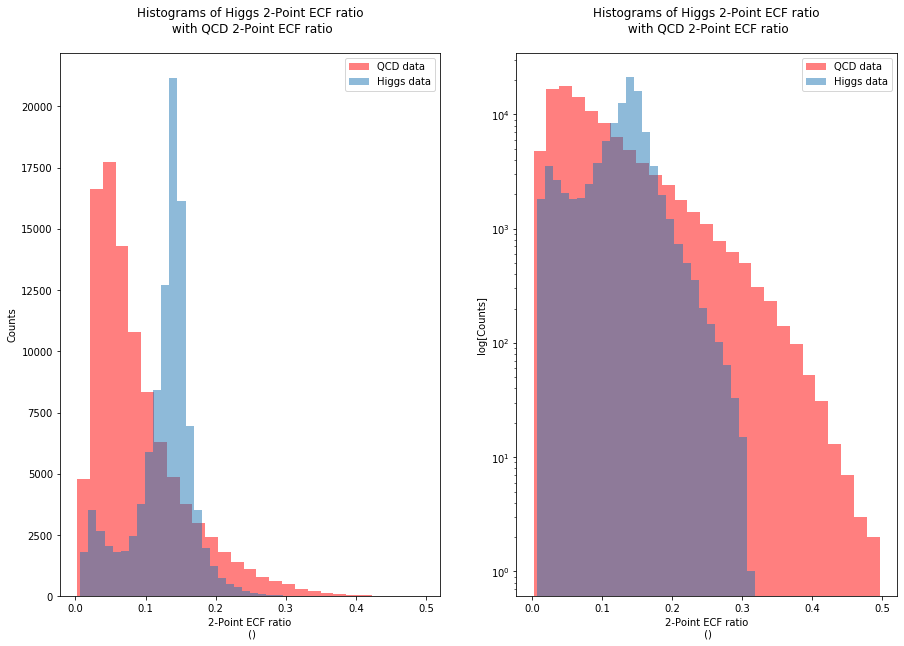

In [61]:
histograms('ee2', '2-Point ECF ratio\n', r'')
minimum_cut_level = 0.0
max_cut_level = 0.3
[minimum_cut_level, max_cut_level] = make_cuts('ee2', minimum_cut_level, max_cut_level)

(0.1229999999999992, 0.15299999999999797)

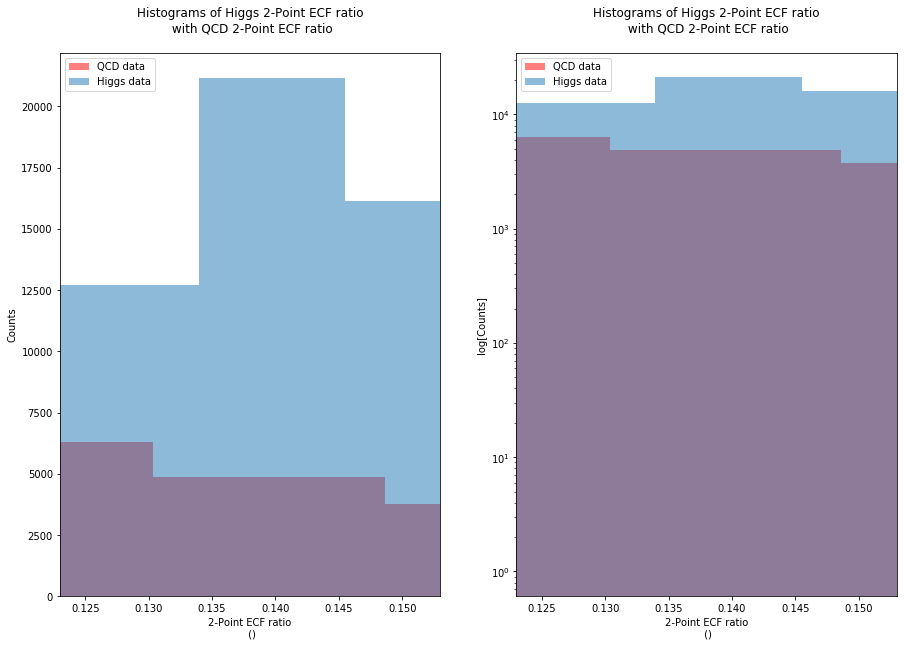

In [62]:
ax = histograms('ee2', '2-Point ECF ratio\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

Min Cut Level:		 0.13
Max Cut Level:		 0.15
Signal-noise Ratio:	 0.028221040189125295
Higgs Counts:		 38
QCD Counts:		 1315


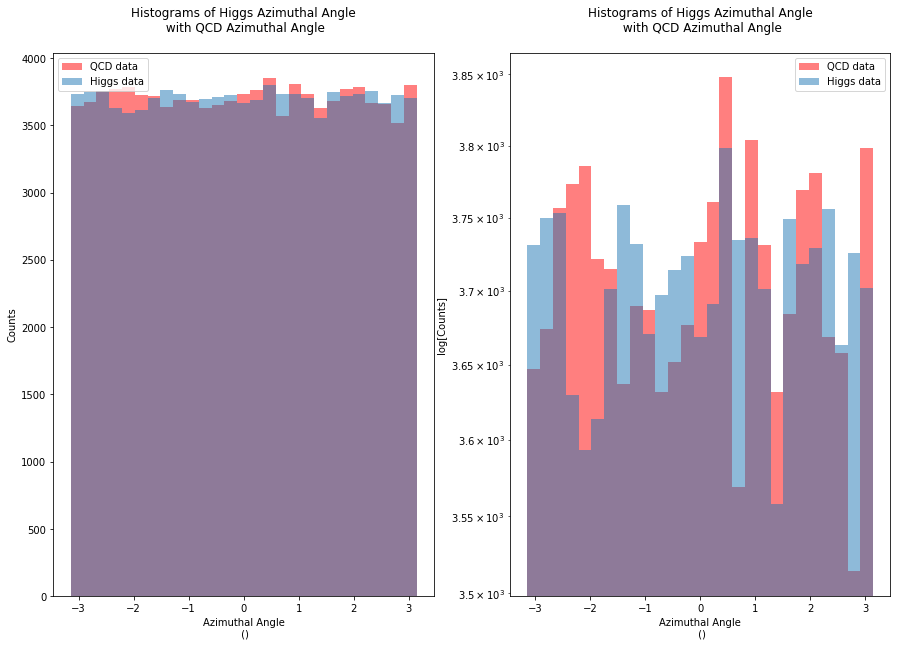

In [63]:
histograms('phi', 'Azimuthal Angle\n', r'')
minimum_cut_level = -3
max_cut_level = 3
[minimum_cut_level, max_cut_level] = make_cuts('ee2', minimum_cut_level, max_cut_level)

This variable clearly has very little difference between the Higgs and QCD data

Min Cut Level:		 0.0014
Max Cut Level:		 0.0033
Signal-noise Ratio:	 0.012396867155845077
Higgs Counts:		 50
QCD Counts:		 4058


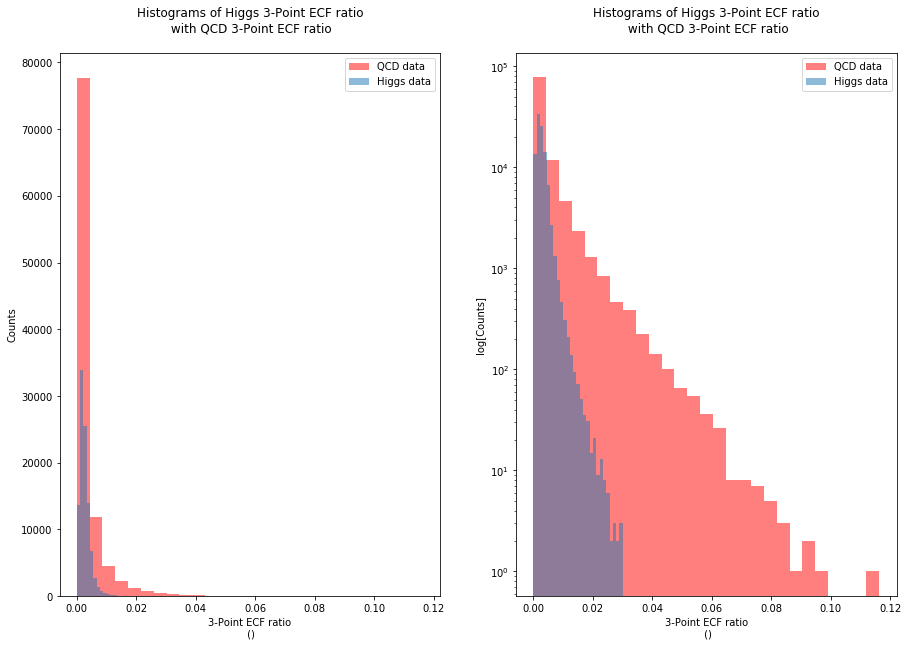

In [64]:
histograms('ee3', '3-Point ECF ratio\n', r'')
minimum_cut_level = 0.00
max_cut_level = 0.03
[minimum_cut_level, max_cut_level] = make_cuts('ee3', minimum_cut_level, max_cut_level)

(0.0014400000000000005, 0.0032700000000004956)

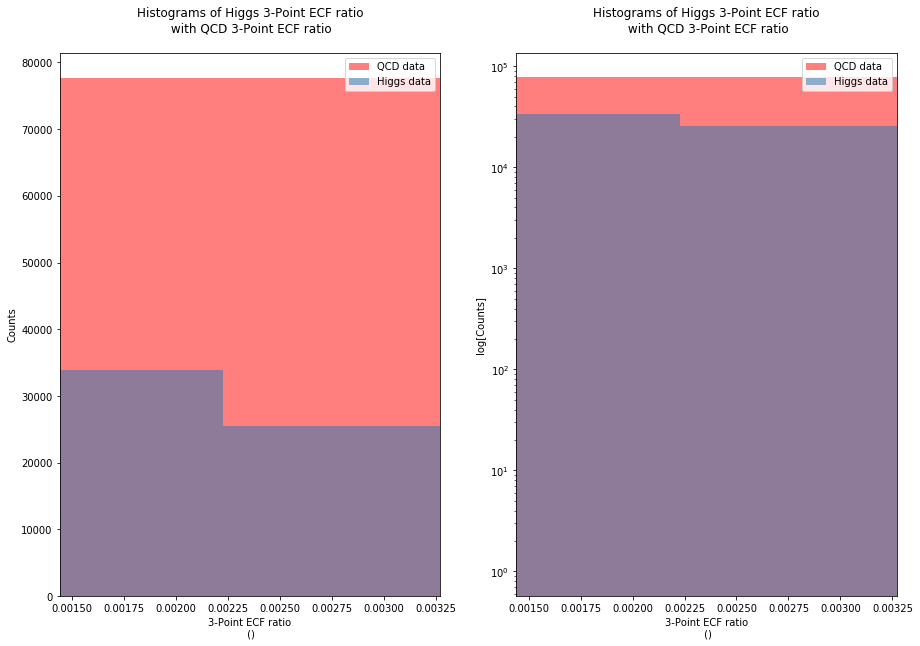

In [65]:
ax = histograms('ee3', '3-Point ECF ratio\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

Min Cut Level:		 0.0
Max Cut Level:		 0.8
Signal-noise Ratio:	 0.10253533767107921
Higgs Counts:		 26
QCD Counts:		 232


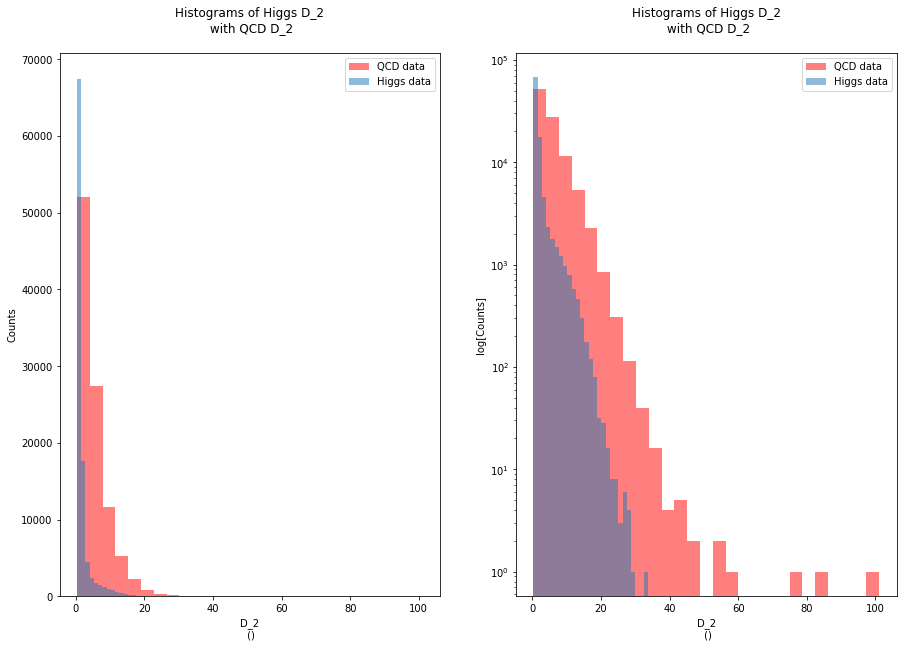

In [66]:
histograms('d2', 'D_2\n', r'')
minimum_cut_level = 0
max_cut_level = 40
[minimum_cut_level, max_cut_level] = make_cuts('d2', minimum_cut_level, max_cut_level)

(0.04, 0.8000000000006757)

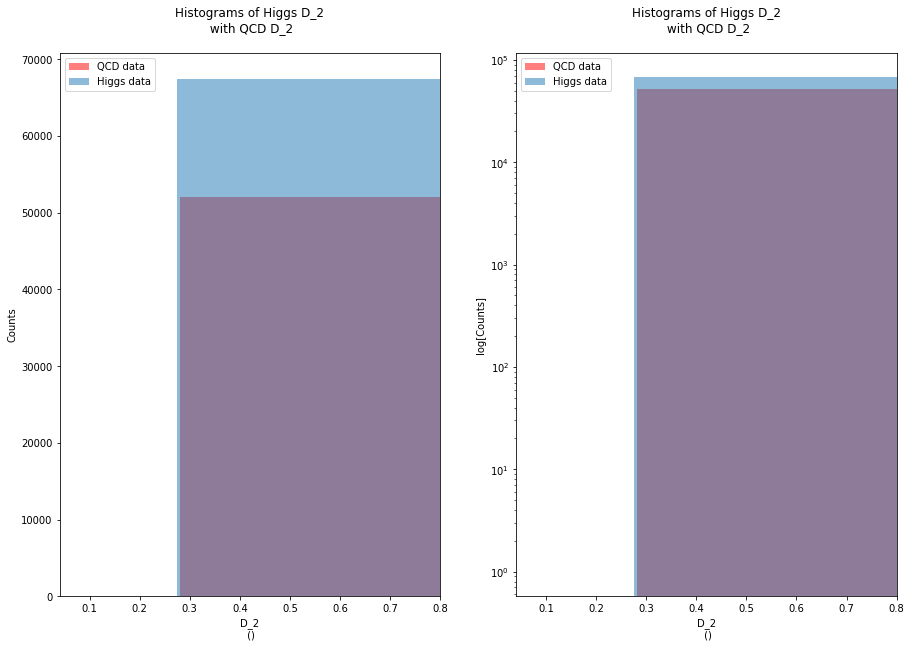

In [68]:
ax = histograms('d2', 'D_2\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4097703518>,
      dtype=object)

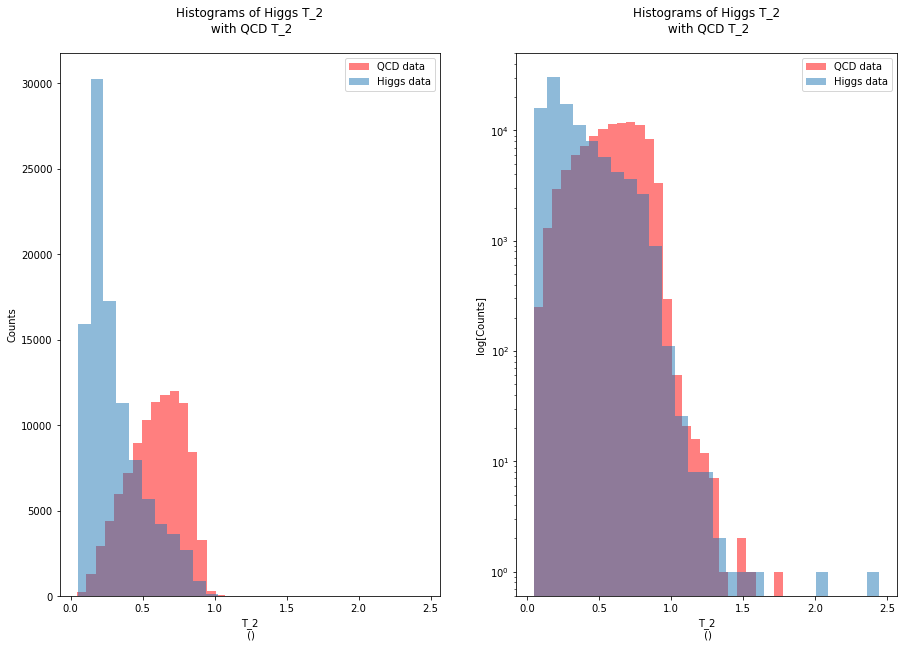

In [76]:
histograms('t2', 'T_2\n', r'')

Min Cut Level:		 0.058
Max Cut Level:		 0.162
Signal-noise Ratio:	 0.09179252244945676
Higgs Counts:		 25
QCD Counts:		 248


(0.057500000000000044, 0.1624999999999997)

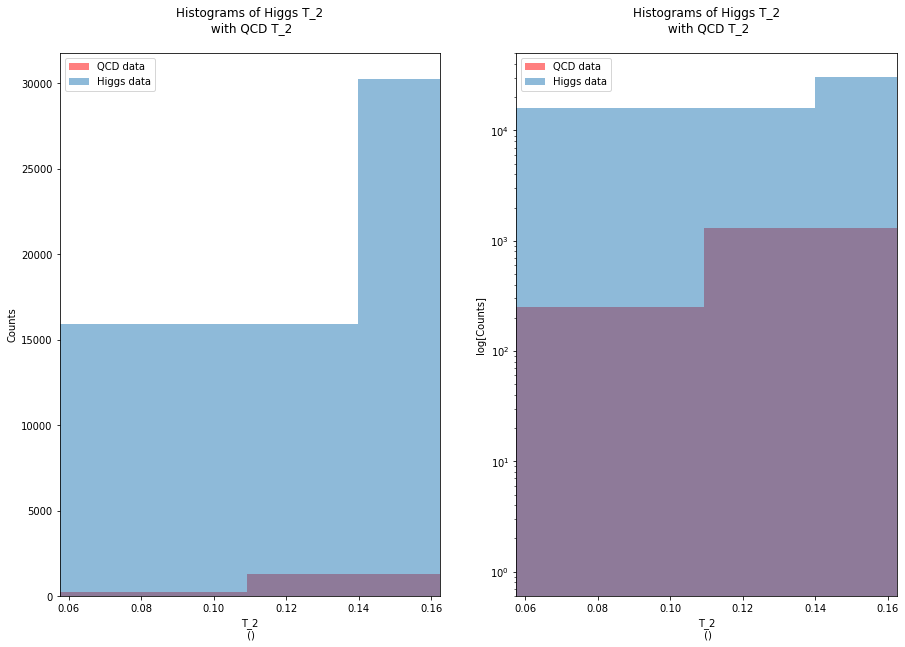

In [78]:
minimum_cut_level = 0
max_cut_level = 0.5
[minimum_cut_level, max_cut_level] = make_cuts('t2', minimum_cut_level, max_cut_level)

ax = histograms('t2', 'T_2\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4096ae6080>,
      dtype=object)

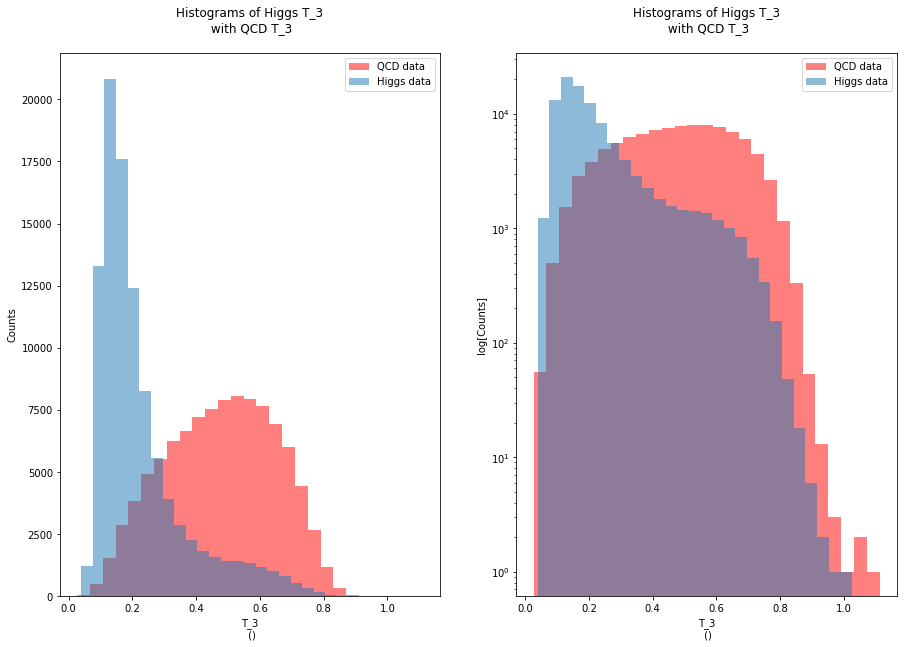

In [82]:
histograms('t3', 'T_3\n', r'')

Min Cut Level:		 0.044
Max Cut Level:		 0.13
Signal-noise Ratio:	 0.08844352083406712
Higgs Counts:		 25
QCD Counts:		 258


(0.04380000000000015, 0.13049999999999837)

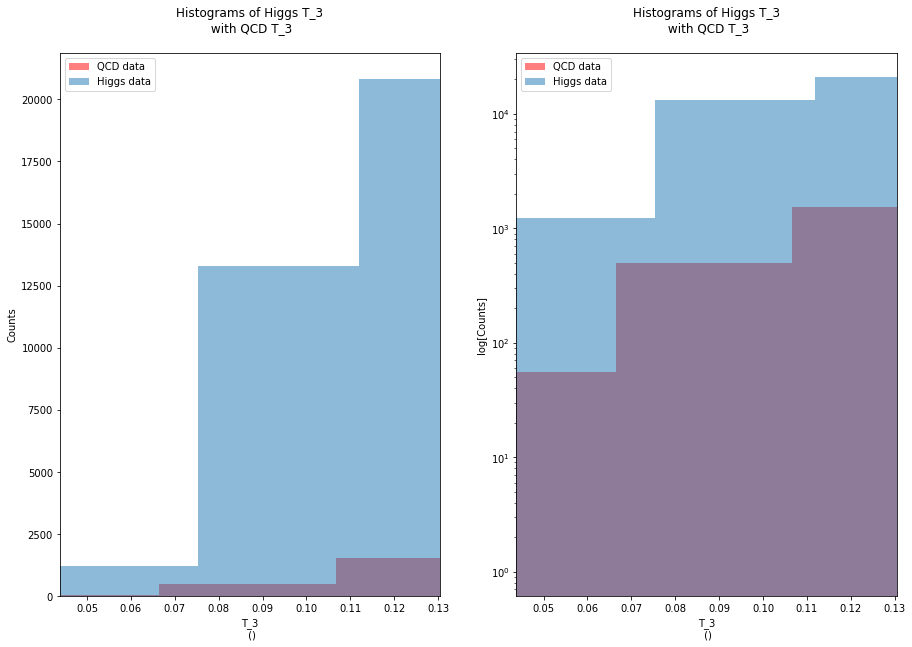

In [81]:
minimum_cut_level = 0
max_cut_level = 0.3
[minimum_cut_level, max_cut_level] = make_cuts('t3', minimum_cut_level, max_cut_level)

ax = histograms('t3', 'T_3\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f409689f550>,
      dtype=object)

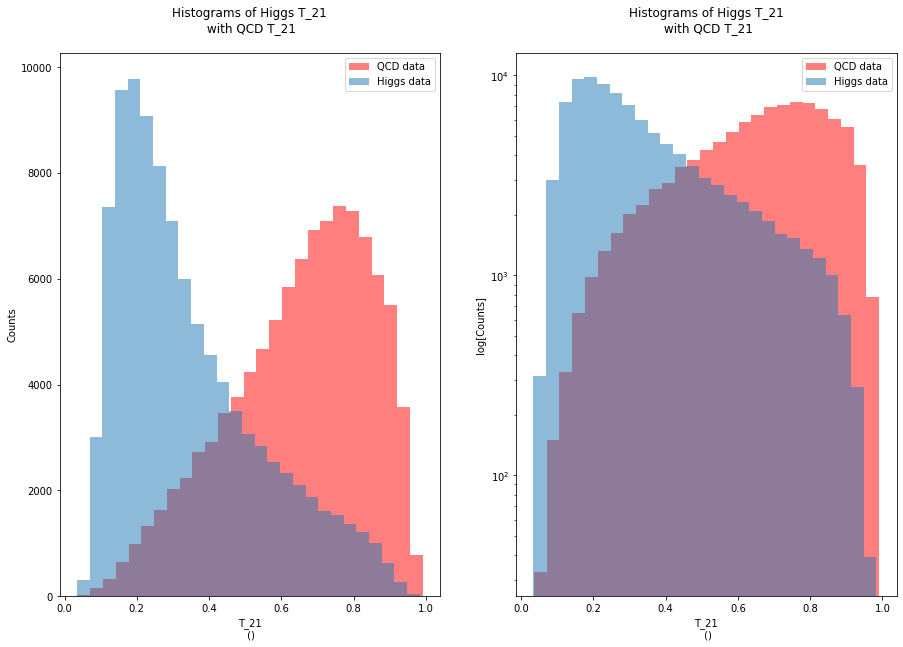

In [84]:
histograms('t21', 'T_21\n', r'')

Min Cut Level:		 0.044
Max Cut Level:		 0.192
Signal-noise Ratio:	 0.07570873376916819
Higgs Counts:		 25
QCD Counts:		 306


(0.044400000000000064, 0.19199999999999795)

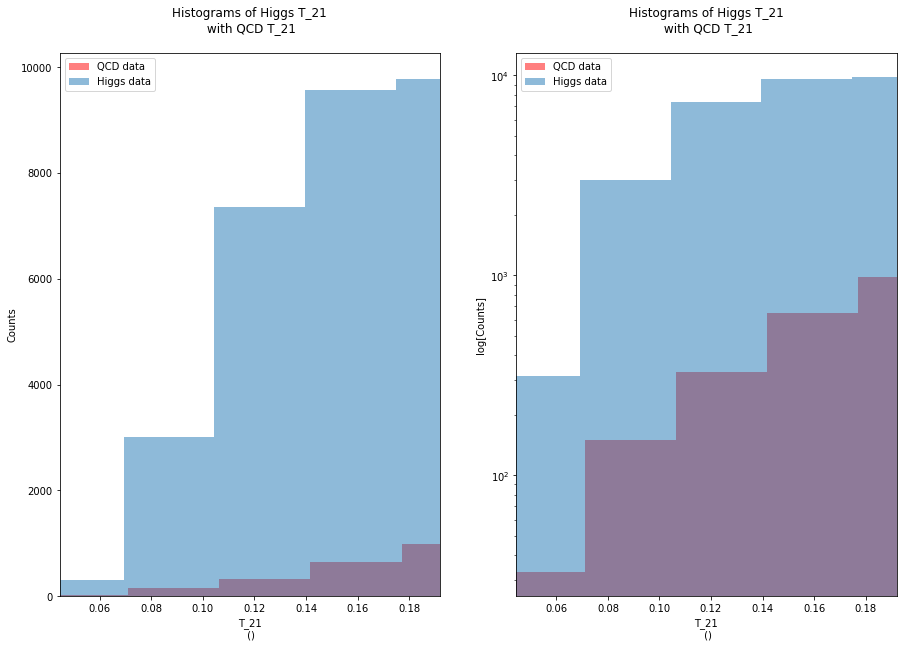

In [87]:
minimum_cut_level = 0
max_cut_level = 0.6
[minimum_cut_level, max_cut_level] = make_cuts('t21', minimum_cut_level, max_cut_level)

ax = histograms('t21', 'T_21\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f409626a048>,
      dtype=object)

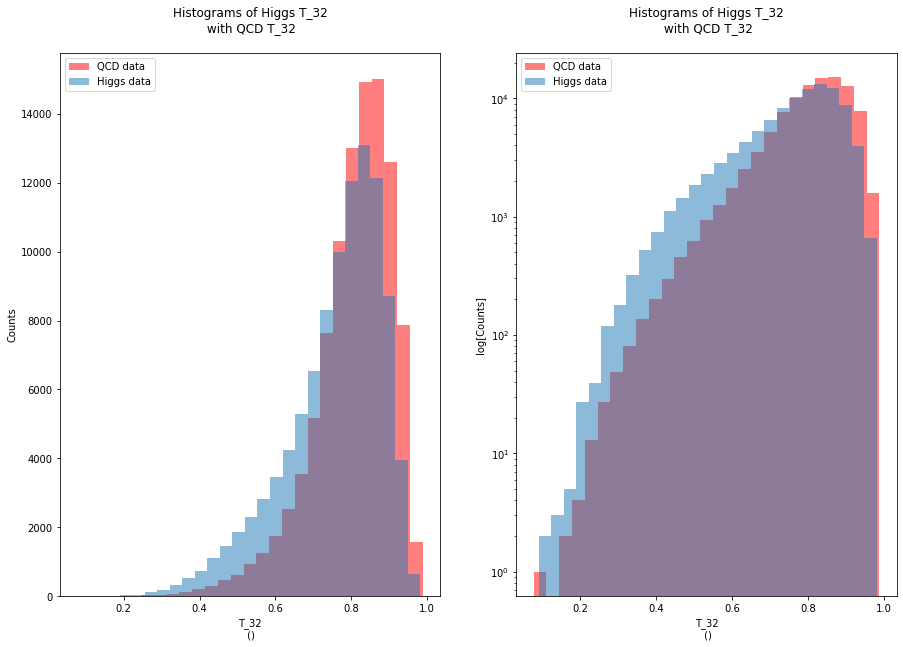

In [88]:
histograms('t32', 'T_32\n', r'')

This variable appears to be almost identically distributed between Higgs and QCD data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4097113780>,
      dtype=object)

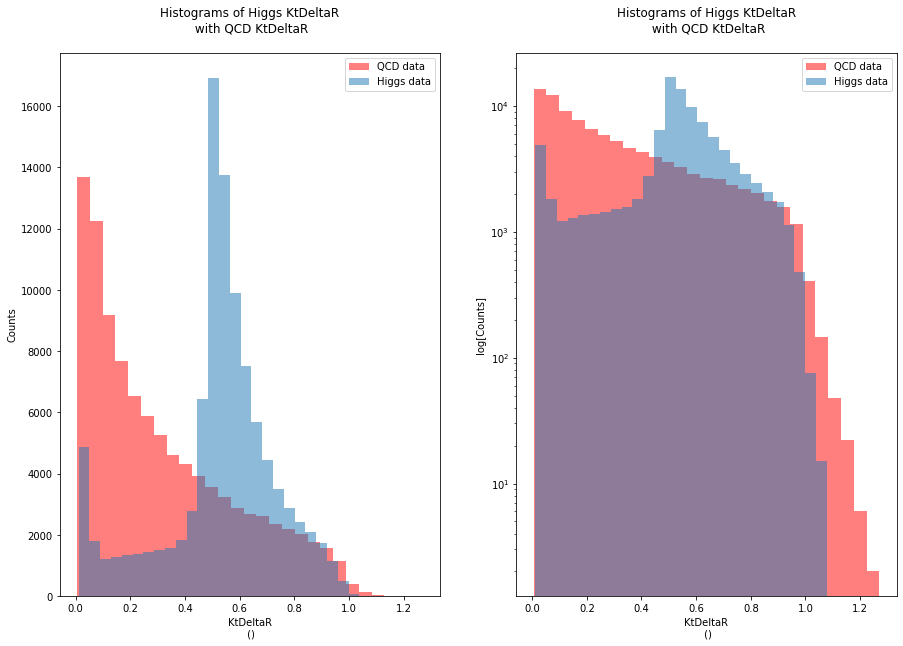

In [91]:
histograms('KtDeltaR', 'KtDeltaR\n', r'')

Min Cut Level:		 0.476
Max Cut Level:		 0.54
Signal-noise Ratio:	 0.02571036412617695
Higgs Counts:		 25
QCD Counts:		 952


(0.4760000000000022, 0.5404000000000286)

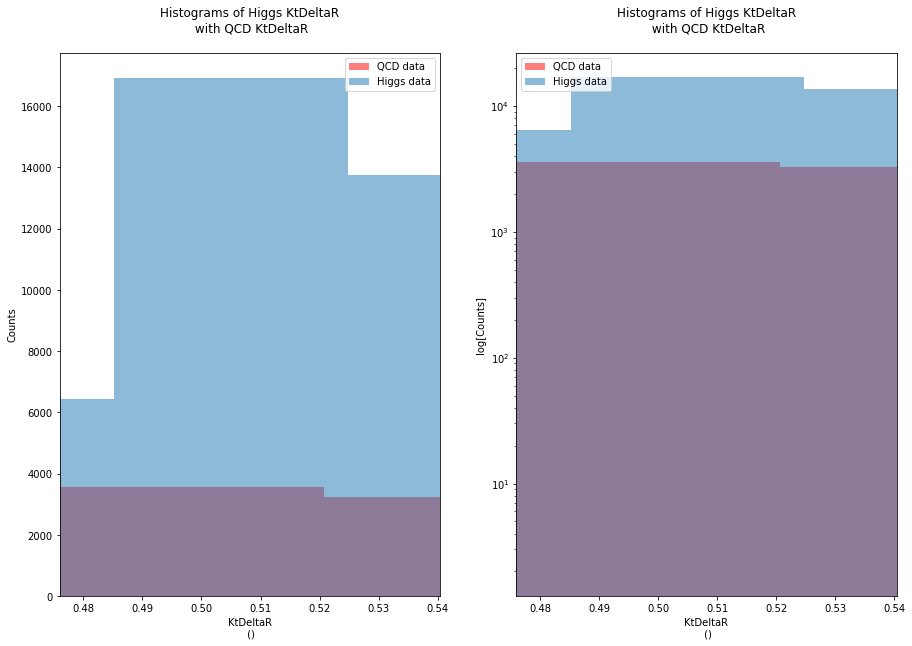

In [96]:
minimum_cut_level = 0.4
max_cut_level = 0.8
[minimum_cut_level, max_cut_level] = make_cuts('KtDeltaR', minimum_cut_level, max_cut_level)

ax = histograms('KtDeltaR', 'KtDeltaR\n', r'')
ax[0].set_xlim([minimum_cut_level,max_cut_level])
ax[1].set_xlim([minimum_cut_level,max_cut_level])

From these plots, it appears that transverse momentum, ECF-2 ratio, t_2, t_3, t_21, and KtDeltaR are variables that we can use to make significant cuts in addition to mass.  Now I need to combine these cuts to try and increase significance even more.